Deep learning on GPU to make a multi classification on fruit images data on Kaggle

#Fruit classification 

Data taken from https://www.kaggle.com/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

#Getting Data from Kaggle

In [ ]:
import tensorflow as tf
print(tf.__version__)
print('GPU available:', tf.test.is_gpu_available())

2.4.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


In [ ]:
import shutil
import os
import pathlib
import zipfile
from glob import glob
import logging
import warnings

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.style as style
from PIL import Image
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from collections import Counter, defaultdict


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D


warnings.filterwarnings('ignore')

Adding Kaggle Json

In [ ]:
api_token = {"username":"nathannguyendev","key":"ed45db0609dbabff92a03cf092311158"}

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

 99% 1.40G/1.41G [00:15<00:00, 77.8MB/s]
100% 1.41G/1.41G [00:15<00:00, 97.9MB/s]


In [ ]:
!mkdir data

In [ ]:
train_zip_path = '/content/fresh-and-stale-images-of-fruits-and-vegetables.zip'

zip_ref = zipfile.ZipFile(train_zip_path, 'r')

zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
!rm /content/data/ImageLabels.txt

Folder Path of Data

Making sample dataset path

In [ ]:
Folder_name = os.listdir('/content/data')

In [ ]:
folder_path = {}
for folder in Folder_name:
    folder_path[folder] = os.path.join('/content/data', folder)

In [ ]:
folder_path

{'fresh_apple': '/content/data/fresh_apple',
 'fresh_banana': '/content/data/fresh_banana',
 'fresh_bitter_gourd': '/content/data/fresh_bitter_gourd',
 'fresh_capsicum': '/content/data/fresh_capsicum',
 'fresh_orange': '/content/data/fresh_orange',
 'fresh_tomato': '/content/data/fresh_tomato',
 'stale_apple': '/content/data/stale_apple',
 'stale_banana': '/content/data/stale_banana',
 'stale_bitter_gourd': '/content/data/stale_bitter_gourd',
 'stale_capsicum': '/content/data/stale_capsicum',
 'stale_orange': '/content/data/stale_orange',
 'stale_tomato': '/content/data/stale_tomato'}

In [ ]:
for fruit in folder_path:
    print('Number of {} is :{}'.format(fruit,len(os.listdir(folder_path[fruit]))))
    

Number of stale_tomato is :982
Number of stale_orange is :1595
Number of fresh_capsicum is :990
Number of stale_apple is :2342
Number of fresh_banana is :1581
Number of stale_capsicum is :901
Number of stale_bitter_gourd is :357
Number of fresh_tomato is :981
Number of fresh_bitter_gourd is :327
Number of stale_banana is :1467
Number of fresh_apple is :1693
Number of fresh_orange is :1466


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Trying to see some Apple pics

In [ ]:
freshapples_fnames = os.listdir(folder_path['fresh_apple'])
rottenapples_fnames = os.listdir(folder_path['stale_apple'])

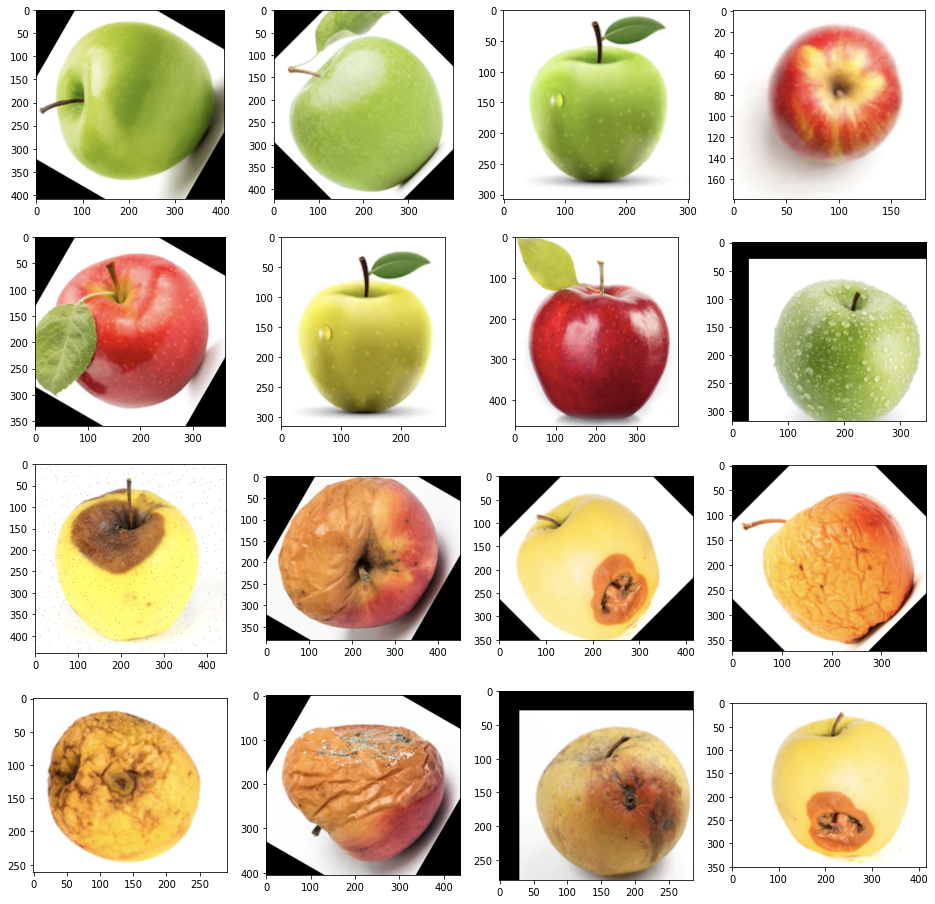

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_freshapples_pix = [os.path.join('/content/data/fresh_apple', fname) 
                for fname in freshapples_fnames[ pic_index-8:pic_index] 
               ]
next_rottenapples_pix = [os.path.join('/content/data/stale_apple', fname) 
                for fname in rottenapples_fnames[ pic_index-8:pic_index] 
               ]

for i, img_path in enumerate(next_freshapples_pix+next_rottenapples_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#Start Building ML

#Data flow 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_datagen = ImageDataGenerator(rescale = 1./255., validation_split=0.2)

In [ ]:
base_dir ='/content/data'

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = image_datagen.flow_from_directory(base_dir,seed=122,shuffle=False, batch_size = 20, subset ="training", class_mode = "categorical",  target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = image_datagen.flow_from_directory(base_dir,seed=122,shuffle=False,  batch_size = 20, subset ="validation", class_mode = "categorical", target_size = (224, 224))

Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.


In [ ]:
class_weight={}
train_dict=train_generator.class_indices
classes=list(train_dict.keys())
class_count=len(classes)
labels=train_generator.labels
count_array=np.zeros((class_count))
for label in labels:
    for value in train_dict.values():
        if label==value:
            count_array[value] +=1    
#print (count_array)
max_samples=np.max(count_array)
msg='{0:^30s}{1:^10s}{2:^9s}'.format('Class', 'Samples', 'Weight')
print(msg)
for i in range (class_count):
    class_weight[i]= max_samples/count_array[i]
    msg=f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print (msg)

            Class              Samples   Weight  
         fresh_apple            1355.0   1.38303 
         fresh_banana           1265.0   1.48142 
      fresh_bitter_gourd        262.0    7.15267 
        fresh_capsicum          792.0    2.36616 
         fresh_orange           1173.0   1.59761 
         fresh_tomato           785.0    2.38726 
         stale_apple            1874.0   1.00000 
         stale_banana           1174.0   1.59625 
      stale_bitter_gourd        286.0    6.55245 
        stale_capsicum          721.0    2.59917 
         stale_orange           1276.0   1.46865 
         stale_tomato           786.0    2.38422 


##Baseline Model

In [ ]:
def model_base():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), input_shape=(224, 224, 3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(12, activation='softmax')
  ])
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss = 'categorical_crossentropy',
               metrics = ['acc'])
  return model

model = model_base()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
activation_24 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
activation_25 (Activation)   (None, 109, 109, 64)    

Plot Func

In [ ]:
def acc_loss_graph(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()
  plt.title('Training and validation accuracy')

  plt.figure()
  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    # Stop training when `val_loss` is no longer improving
    monitor='val_loss',
    # "no longer improving" being defined as "no better than 1e-2 less"
    min_delta=1e-2,
    # "no longer improving" being further defined as "for at least 5 epochs", 
    # you can choose a lower number if you are impatient
    patience=5,
    verbose=1)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_Base_model_checkpoint_{epoch}.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

Training on baseline

In [ ]:

history = model.fit(
      train_generator,
      epochs=60,class_weight=class_weight,
      validation_data=validation_generator,
      callbacks=[checkpoint_callback, earlystopping_callback], # Pass callback to training
      verbose=True)

Epoch 1/60
588/588 [==============================] - 63s 107ms/step - loss: 3.7747 - acc: 0.3820 - val_loss: 0.8465 - val_acc: 0.6744

Epoch 00001: val_loss improved from inf to 0.84650, saving model to my_Base_model_checkpoint_1.h5
Epoch 2/60
588/588 [==============================] - 62s 106ms/step - loss: 1.1726 - acc: 0.7571 - val_loss: 0.5662 - val_acc: 0.7917

Epoch 00002: val_loss improved from 0.84650 to 0.56620, saving model to my_Base_model_checkpoint_2.h5
Epoch 3/60
588/588 [==============================] - 62s 106ms/step - loss: 0.7655 - acc: 0.8352 - val_loss: 0.5026 - val_acc: 0.8149

Epoch 00003: val_loss improved from 0.56620 to 0.50258, saving model to my_Base_model_checkpoint_3.h5
Epoch 4/60
588/588 [==============================] - 63s 107ms/step - loss: 0.5573 - acc: 0.8753 - val_loss: 0.4245 - val_acc: 0.8479

Epoch 00004: val_loss improved from 0.50258 to 0.42448, saving model to my_Base_model_checkpoint_4.h5
Epoch 5/60
588/588 [==============================] 

Plot of Baseline

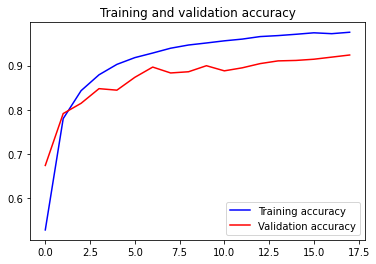

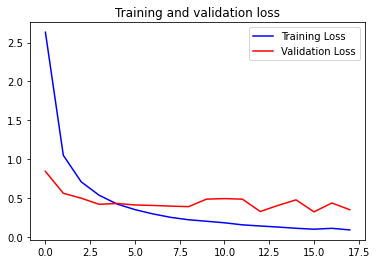

In [ ]:
acc_loss_graph(history)

###Confusion Matrix

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [ ]:
restored_model = tf.keras.models.load_model('my_Base_model_checkpoint_16.h5')

# Show the model architecture
restored_model.summary()

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
restored_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss = 'categorical_crossentropy',
               metrics = ['acc'])
# Re-evaluate the model
loss, acc = restored_model.evaluate(validation_generator)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
activation_24 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
activation_25 (Activation)   (None, 109, 109, 64)    

##Transfer Learning Model

Using MobileNet with Image net weighth to speed up model training and have a reasonable complicated model

In [ ]:
def build_model_MobileNetV2(trainable = True, fine_tune_at = 5):
    """Build a Sequential model with the MobileNetv2 as base model and additional top layers.
       The MobileNetv2 can be trained with certain number of layers.
       args:
           trainable: boolean, dictate whether transfer learning model can be trained or not.
           fine_tune_at: int, dictate the number of trainable layers.
    
    """
    MBv2 = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    if trainable == True:
        MBv2.trainable=True

        for layer in MBv2.layers[:fine_tune_at]:
            layer.trainable = False
    else: 
        MBv2.trainable = False
    
    model = tf.keras.Sequential([
        MBv2,
        Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(12, activation = 'softmax')])  
    
    return model

In [ ]:
model_MB = build_model_MobileNetV2()
model_MB.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_16 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               32113152  
_________________________________________________________________
dense_52 (Dense)             (None, 12)                6156      
Total params: 34,377,292
Trainable params: 34,341,964
Non-trainable params: 35,328
_________________________________________________________________


Some Callback

In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    # Stop training when `val_loss` is no longer improving
    monitor='val_loss',
    # "no longer improving" being defined as "no better than 1e-2 less"
    min_delta=1e-2,
    # "no longer improving" being further defined as "for at least 5 epochs", 
    # you can choose a lower number if you are impatient
    patience=5,
    verbose=1)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_modelMB2_checkpoint_{epoch}.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

Start Fitting

In [ ]:
model_MB.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000002),
               loss = 'categorical_crossentropy',
               metrics = ['acc',tf.keras.metrics.Recall()])

In [ ]:
history_MB = model_MB.fit(
      train_generator,
      epochs=60,class_weight=class_weight,
      validation_data=validation_generator,
      callbacks=[checkpoint_callback, earlystopping_callback], # Pass callback to training
      verbose=True)

Epoch 1/60
588/588 [==============================] - 76s 123ms/step - loss: 5.8383 - acc: 0.1158 - recall_12: 0.0263 - val_loss: 2.2677 - val_acc: 0.2567 - val_recall_12: 0.0651

Epoch 00001: val_loss improved from inf to 2.26775, saving model to my_modelMB2_checkpoint_1.h5
Epoch 2/60
588/588 [==============================] - 72s 122ms/step - loss: 3.5335 - acc: 0.3574 - recall_12: 0.1347 - val_loss: 1.6079 - val_acc: 0.4620 - val_recall_12: 0.2114

Epoch 00002: val_loss improved from 2.26775 to 1.60792, saving model to my_modelMB2_checkpoint_2.h5
Epoch 3/60
588/588 [==============================] - 72s 122ms/step - loss: 2.2945 - acc: 0.5728 - recall_12: 0.3424 - val_loss: 1.2072 - val_acc: 0.5960 - val_recall_12: 0.3887

Epoch 00003: val_loss improved from 1.60792 to 1.20721, saving model to my_modelMB2_checkpoint_3.h5
Epoch 4/60
588/588 [==============================] - 72s 122ms/step - loss: 1.5843 - acc: 0.6995 - recall_12: 0.5334 - val_loss: 0.9249 - val_acc: 0.7020 - val_rec

##Plotting History

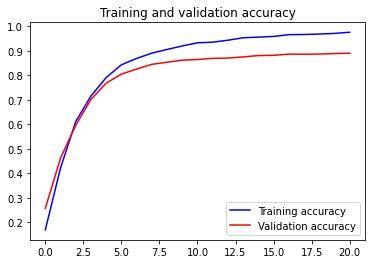

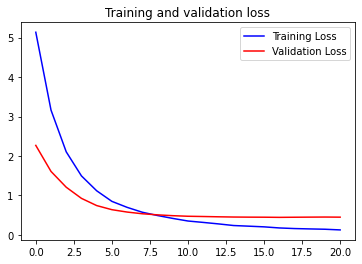

In [ ]:
acc_loss_graph(history_MB)

Much smoother learning curve that indicate over fitting has not happened yet

##Testing on Upload Image

In [ ]:
restored_model = tf.keras.models.load_model('/content/drive/MyDrive/my_modelMB2_checkpoint_20.h5')

# Show the model architecture
restored_model.summary()

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
restored_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss = 'categorical_crossentropy',
               metrics = ['acc'])
# Re-evaluate the model
# loss, acc = restored_model.evaluate(validation_generator)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_13 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               32113152  
_________________________________________________________________
dense_46 (Dense)             (None, 12)                6156      
Total params: 34,377,292
Trainable params: 32,119,308
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
restored_model.evaluate(validation_generator)

147/147 [==============================] - 30s 91ms/step - loss: 0.3797 - acc: 0.8910


[0.3993825614452362, 0.8861234188079834]

Confusion Matrix showing that the model is not good, but somehow accuracy is so high ????

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
class_names=list(validation_generator.class_indices.keys())
uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img).astype('float32')
  x = x/255.0
  x=np.expand_dims(x, axis=0)
  
  classes = model.predict_classes(x)
  
  print("Predicted Class:",class_names[list(classes)[0]])
 

Saving images (1).jpg to images (1).jpg
Predicted Class: stale_banana


##Conclusion

Checking for confusion matrix

In [ ]:
y_true_train = validation_generator.classes
# y_pred=model.predict_classes(train_generator)
y_pred_train = np.argmax(restored_model.predict(validation_generator),axis=1) 

Confusion matrix, without normalization


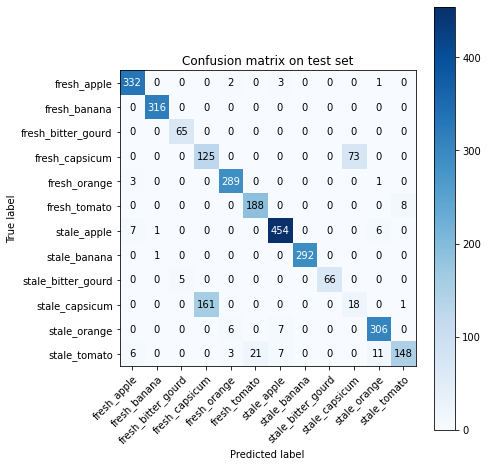

In [ ]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true_train, y_pred_train)

#Defining the class labels
class_names=list(train_generator.class_indices.keys())

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true_train, y_pred_train, classes = class_names, title='Confusion matrix on test set')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       338
           1       0.99      1.00      1.00       316
           2       0.93      1.00      0.96        65
           3       0.44      0.63      0.52       198
           4       0.96      0.99      0.97       293
           5       0.90      0.96      0.93       196
           6       0.96      0.97      0.97       468
           7       1.00      1.00      1.00       293
           8       1.00      0.93      0.96        71
           9       0.20      0.10      0.13       180
          10       0.94      0.96      0.95       319
          11       0.94      0.76      0.84       196

    accuracy                           0.89      2933
   macro avg       0.85      0.86      0.85      2933
weighted avg       0.88      0.89      0.88      2933



Model got a pretty good accuracy overall
- Some of the weird data from capsicum and bitter gourd have bad accuracy but it is possible due to bad data collection